In [1]:
# Import
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

!pip install gym pyvirtualdisplay > /dev/null 2>&1

!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

     |████████████████████████████████| 538 kB 9.9 MB/s 
     |████████████████████████████████| 448 kB 44.6 MB/s 
  Created wheel for PyOpenGL-accelerate: filename=PyOpenGL_accelerate-3.1.5-cp37-cp37m-linux_x86_64.whl size=1599530 sha256=7c78d21cf32970d9f8cc38cd4a5044dcd49507ebfd5f19396baa82802bb70fa2
  Stored in directory: /root/.cache/pip/wheels/1c/f5/6f/169afb3f2d476c5e807f8515b3c9bc9b819c3962316aa804eb
Successfully built PyOpenGL-accelerate
  Attempting uninstall: pyvirtualdisplay
    Found existing installation: PyVirtualDisplay 3.0
    Uninstalling PyVirtualDisplay-3.0:
      Successfully uninstalled PyVirtualDisplay-3.0


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [2]:
import numpy as np
import random
import gym
import math
from collections import defaultdict, deque
import matplotlib.pyplot as plt

ENV = "BipedalWalker-v3"

EPISODES = 500
GAMMA =  0.99
ALPHA = 0.01
HIGHSCORE = -200

stateBounds = [(0, math.pi),
           (-2,2),
           (-1,1),
           (-1,1),
           (0,math.pi),
           (-2,2),
           (0, math.pi),
           (-2,2),
           (0,1),
           (0, math.pi),
           (-2, 2),
           (0, math.pi),
           (-2, 2),
           (0, 1)]

actionBounds = (-1, 1)

In [3]:
def updateQTable (Qtable, state, action, reward, nextState=None):
    global ALPHA
    global GAMMA

    current = Qtable[state][action]  
    qNext = np.max(Qtable[nextState]) if nextState is not None else 0
    target = reward + (GAMMA * qNext)
    new_value = current + (ALPHA * (target - current))
    return new_value

def getNextAction(qTable, epsilon, state):
    if random.random() < epsilon:
        action = ()
        for i in range (0, 4):
            action += (random.randint(0, 9),)

    else:
        action = np.unravel_index(np.argmax(qTable[state]), qTable[state].shape)

    return action

def discretizeState(state):
    discreteState = []

    for i in range(len(state)):
        index = int((state[i]-stateBounds[i][0])  / (stateBounds[i][1]-stateBounds[i][0])*19)
        discreteState.append(index)
    
    return tuple(discreteState)


def convertNextAction(nextAction):
    action = []

    for i in range(len(nextAction)):
        nextVal = nextAction[i] / 9 * 2 - 1
        action.append(nextVal)

    return tuple(action)

def plotEpisode(myGraph, xval, yval, epScore, plotLine, i):
    xval.append(i)
    yval.append(epScore)

    plotLine.set_xdata(xval)
    plotLine.set_ydata(yval)
    myGraph.savefig("./plot")

def runAlgorithmStep(env, i, qTable, doRender):
    global HIGHSCORE

    if(doRender):
        env.render()

    state = discretizeState(env.reset()[0:14])
    total_reward = 0
    epsilon = 1.0 / ( i * .004)

    while True: 
        nextAction = convertNextAction(getNextAction(qTable, epsilon, state))
        nextActionDiscretized = getNextAction(qTable, epsilon, state)
        nextState, reward, done, info = env.step(nextAction)
        nextState = discretizeState(nextState[0:14])
        total_reward += reward
        qTable[state][nextActionDiscretized] = updateQTable(qTable, state, nextActionDiscretized, reward, nextState)
        state = nextState
        if done:
            break
    
    if total_reward > HIGHSCORE:
        HIGHSCORE = total_reward

    return total_reward

Visualize? [y/n]
n


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


All episodes finished. Highest score achieved: -82.12170963743588


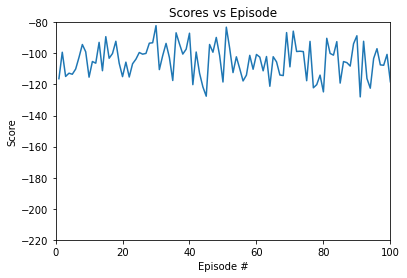

In [4]:
global HIGHSCORE
    
visualize = input("Visualize? [y/n]\n")
if visualize == 'y':
    doRender = True
else:
    doRender = False

env = gym.make(ENV)

qTable = defaultdict( lambda: np.zeros((10, 10, 10, 10)))

myGraph = plt.figure()
xval, yval = [], []
mySubPlot = myGraph.add_subplot()
plt.xlabel("Episode #")
plt.ylabel("Score")
plt.title("Scores vs Episode")
plotLine, = mySubPlot.plot(xval, yval)
mySubPlot.set_xlim([0, EPISODES])
mySubPlot.set_ylim([-220, -80])


for i in range(1, EPISODES + 1):
    epScore = runAlgorithmStep(env, i, qTable, doRender)
    #print("Episode finished. Now plotting..")
    plotEpisode(myGraph, xval, yval, epScore, plotLine, i)
    
print("All episodes finished. Highest score achieved: " + str(HIGHSCORE))